## <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Assignment 7: Bank Churn Prediction </span>


<p align="center" style="font-family: Arial;color:#0e92ea;font-size:1em;">
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.
</p>

##  <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#0e92ea">Data Dictionary:</span>

<ol style="font-family: Arial;color:#0e92ea;font-size:1em;">
    <li>CustomerId: Unique ID which is assigned to each customer</li>
    <li>Surname: Last name of the customer</li> 
    <li>CreditScore: It defines the credit history of the customer.</li>  
    <li>Geography: A customer’s location</li>    
    <li>Gender: It defines the Gender of the customer</li>   
    <li>Age: Age of the customer</li>     
    <li>Tenure: Number of years for which the customer has been with the bank</li>
    <li>NumOfProducts: It refers to the number of products that a customer has purchased through the bank.</li>
    <li>Balance: Account balance</li>
    <li>HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.</li>
    <li>EstimatedSalary: Estimated salary</li> 
    <li>isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
    <li>Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values</li>
        <ul>
            <li>0=No ( Customer did not leave the bank )</li>
            <li>1=Yes ( Customer left the bank )</li>
        </ul>
    </li>
</ol>

In [1]:
import keras
import warnings
import random
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
main_data = pd.read_csv('Dataset - bank.csv')

# Data Eploration

In [2]:
main_data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
main_data.shape

(10000, 14)

### Drop ID Based Columns

- `RowNumber`: Row number is not likely to repeat itself or any helpful in generalizing the data so we can drop this value.
- `CustomerId`: Same applies to customer Id. It uniquely identifies the customer but does not help us categorise and generalize for unseen data/test data as it does not repeat itself.
- `Surname`: We can argue that people with a specific surname might belong to the same family and are more/less likely to leave but this is just stereotyping. People of the same surname dont all all belong to the same family so this feature can be left out too.

In [4]:
FEATURES_TO_DROP = ['RowNumber', 'CustomerId', 'Surname']
main_data.drop(FEATURES_TO_DROP, axis=1, inplace=True)
main_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
'''
Input:
Pandas DataFrame

Output:
Displays DataFrame structure 
(columns, nulls and non nulls counts and percentage highlighing columns with most number of nulls)

Retunrs:
N/A
'''
def info(dataFrame):
    print(f"{dataFrame.shape[0]} Rows x {dataFrame.shape[1]} Columns")
    missing_values             = dataFrame.isna().sum()         # Get a series counting number of empty values for each column
    non_missing_values         = dataFrame.notnull().sum()      # Get a series counting number of non empty valuesfor each column 
    missing_values_percentage  = ((missing_values * 100)/(missing_values + non_missing_values)).astype(float)
    column_datatypes           = dataFrame.dtypes               # Get a series containing data types for each column 
    
    features      = [missing_values, missing_values_percentage, column_datatypes]
    feature_names = ["No. Of Missing Values", "Missing Values %", "Data Type"]
    
    df = pd.concat(
        objs = features,
        axis = 1,
        keys = feature_names, 
        sort = True)
    
    cm = sns.light_palette("red", as_cmap=True)
    display(df.style.background_gradient(cmap=cm, subset=pd.IndexSlice[:, feature_names[1]]).format(formatter={(feature_names[1]): "{:.2f}%"})) 

In [6]:
info(main_data)

10000 Rows x 11 Columns


,No. Of Missing Values,Missing Values %,Data Type
Age,0,0.00%,int64
Balance,0,0.00%,float64
CreditScore,0,0.00%,int64
EstimatedSalary,0,0.00%,float64
Exited,0,0.00%,int64
Gender,0,0.00%,object
Geography,0,0.00%,object
HasCrCard,0,0.00%,int64
IsActiveMember,0,0.00%,int64
NumOfProducts,0,0.00%,int64


In [7]:
main_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Split The Data

In [8]:
# Separating data into X and Y

TARGET_COLUMN = "Exited"

X = main_data.drop([TARGET_COLUMN], axis = 1)
Y = main_data[TARGET_COLUMN]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(x_train.shape, x_test.shape)

(8000, 10) (2000, 10)


In [9]:
model_data = {
    "x_train": x_train,
    "y_train": y_train,
    "x_test" : x_test,
    "y_test" : y_test,
}

In [10]:
unique_items = y_test.unique()
print(unique_items)
NUMBER_OF_CLASSES = len(unique_items)

[0 1]


### Fix Data Types

In [11]:
'''
Input:
Target type and a list of feature names.

Output:
Convert all features with type 'object' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''
def TransformDataType(column_names, toType = "category", data = np.nan):
    for col_name in column_names:
        data['x_train'][col_name] = data['x_train'][col_name].astype(toType)
        data['x_test'][col_name] = data['x_test'][col_name].astype(toType)
        
    print(f"Data Types Converted for features: {column_names}")       

TransformDataType(["Gender", "Geography", "HasCrCard", "IsActiveMember"], 'category', model_data)
x_train.head(2)

Data Types Converted for features: ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82


# Exploratory Data Analysis

In [12]:
default_color_palette  = ['dodgerblue', 'crimson', 'gold', "#03A9F4","#7C4DFF", "#FF5252", "#D50000", "#FF6F00", "#0288D1", "#7C4DFF"]
stats_colors           = {'Mean':'#D50000', 'Mode':'#FF3D00', 'Median':'#2962FF'} # Set standard colors for mean, mode and median to use accross entire notebook.
gender_color_palette   = {"Female":"#E91E63", "Male":"#42A5F5"} # Gender based colors.

In [13]:
x_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82
2568,612,Germany,Female,47,6,130024.87,1,1,1,45750.21
3671,646,Germany,Female,52,6,111739.40,2,0,1,68367.18
7427,714,Spain,Male,33,8,122017.19,1,0,0,162515.17
...,...,...,...,...,...,...,...,...,...,...
2895,621,Germany,Male,47,7,107363.29,1,1,1,66799.28
7813,684,Germany,Female,63,3,81245.79,1,1,0,69643.31
905,672,France,Female,45,9,0.00,1,1,1,92027.69
5192,663,France,Female,39,8,0.00,2,1,1,101168.90


### Check for Balanced Data

In [14]:
'''
Input:
N/A

Output:
Go through each categorial column and print unique values for that column.

Retunrs:
N/A
'''
def CountUniqueValues(df):
    col_names = df.select_dtypes(include=['category']).columns.tolist()
    for col_name in col_names:
        print(f"======================='{col_name}'==================")
        for unique_col_value in  df[col_name].unique().tolist():
            total_count = df[col_name].count()
            unique_values_count = df[df[col_name] == unique_col_value][col_name].count()
            percentage = str(round((unique_values_count/total_count) * 100, 2))
            print(f"{unique_col_value} \t: {unique_values_count} ({percentage}%)")
        print(f"=========================================================\n")  


In [15]:
temp_df = pd.concat([model_data['x_train'], model_data['y_train']], axis=1)
temp_df['Exited'] = temp_df['Exited'].astype('category')
CountUniqueValues(temp_df)

======================='Geography'==================
Germany 	: 2030 (25.37%)
France 	: 3994 (49.92%)
Spain 	: 1976 (24.7%)

======================='Gender'==================
Male 	: 4354 (54.42%)
Female 	: 3646 (45.58%)

======================='HasCrCard'==================
0 	: 2344 (29.3%)
1 	: 5656 (70.7%)

======================='IsActiveMember'==================
1 	: 4092 (51.15%)
0 	: 3908 (48.85%)

======================='Exited'==================
0 	: 6378 (79.72%)
1 	: 1622 (20.28%)



### Observations
- The data is very imbalanced with 79.72%  of the bank's customers who have left the bank and 20% who stayed.


## Univariate Analysis

### Observations based on Gender
- The bank has more customers in France and almmost equal number of customers in both Gemerny and Spain.
- The bank has a relatively equal number of male and females in all categories
- Theres more customers who have a credit card than those who do not.
- The ratio of active members to inactive members is aproximately 50/50

In [16]:
'''
Description:
Displays a grid catplots

Input:
A list of column names
'''
def DisplayCountPlotGrid(col_names, hue_name, color_palette, df):
    col_index = 0
    for r in range(0, int(len(col_names)), 2):
        fig, axs = plt.subplots(
            nrows=1,                                                                # Number of rows of the grid
            ncols=2,                                                                # Number of columns of the grid.
            figsize=(15,6),
            constrained_layout=True)

        for index in range(0, 2):
            if col_index < int(len(col_names)):
                column_name = col_names[col_index]
                ax = axs.flat[index]
                ax = sns.countplot(
                    data    = df,
                    x       = df[column_name],
                    palette = color_palette,
                    hue     = hue_name,
                    ax      = ax)
                ax.set_xlabel(column_name)                                           
                ax.set_title(column_name + ' and '+ hue_name +' Profile', fontsize=14)

                total = 0
                for p in ax.patches:
                    if p.get_height() > 0:
                        total += p.get_height()

                for p in ax.patches:
                    if p.get_height() > 0:
                        percentage = str(((p.get_height() / total) * 100).round(1))+ '%'
                        txt_x = p.get_x() + p.get_width()/4
                        txt_y = p.get_height() - p.get_height()/4
                        ax.text(txt_x,txt_y, percentage, color="white", weight="bold")
                     
                if int(len(ax.get_xticklabels())) > 14: 
                    ax.set_xticklabels([], rotation=45, ha='right')
                else:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            col_index += 1

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']


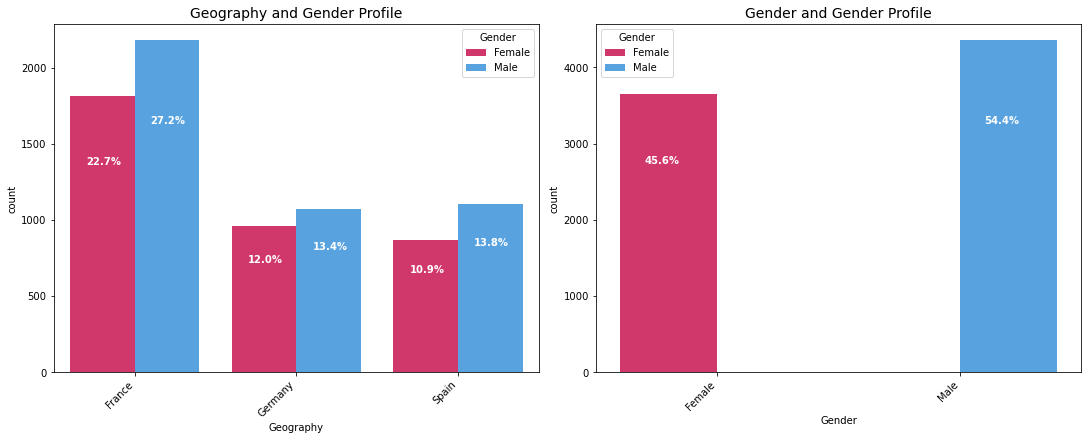

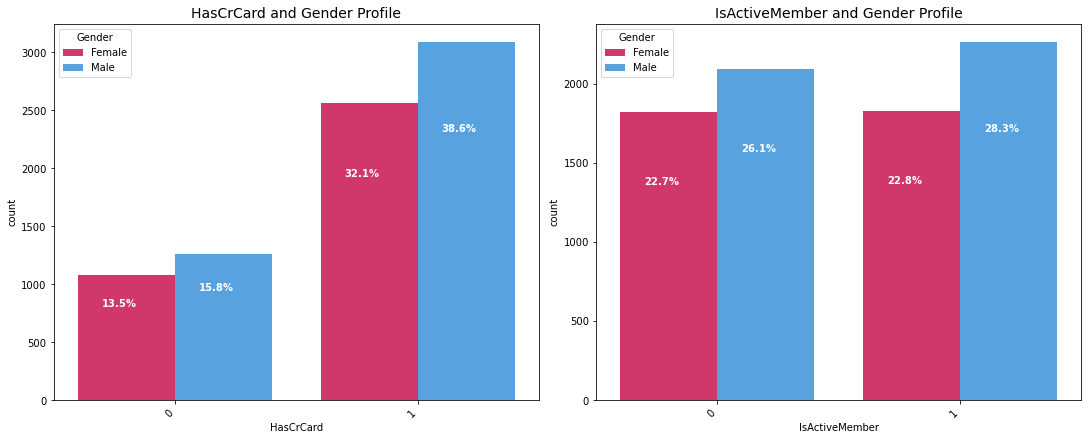

In [17]:
catgry_col_names = x_train.select_dtypes(include=['category']).columns.tolist()
print(catgry_col_names)

DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "Gender",
    color_palette = gender_color_palette,
    df            = x_train)

### Observations based on Geography
- Same observation as in above

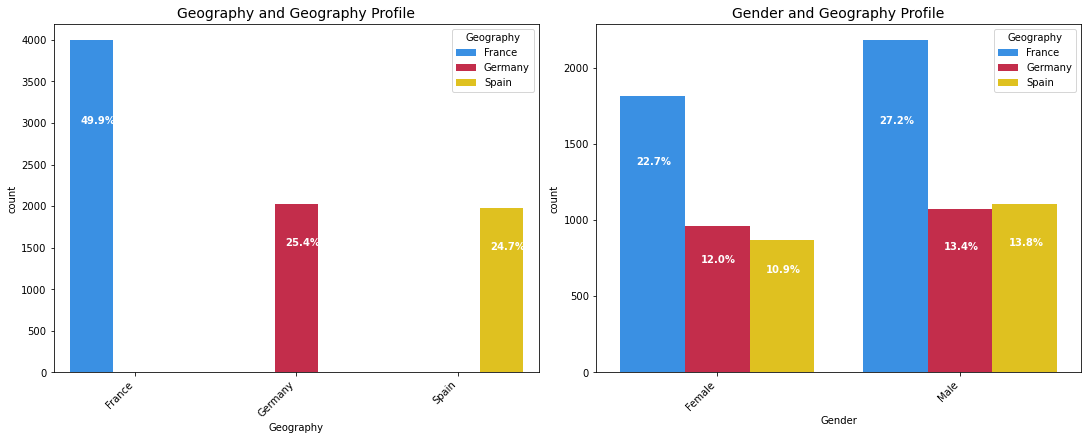

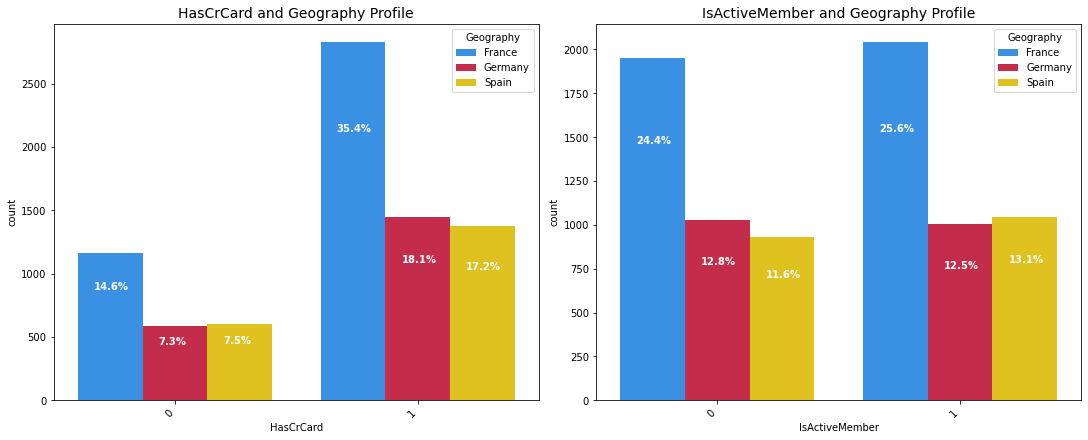

In [18]:
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "Geography",
    color_palette = default_color_palette,
    df            = x_train)

### Observations based on Credit Card Status
- Same observation as in above

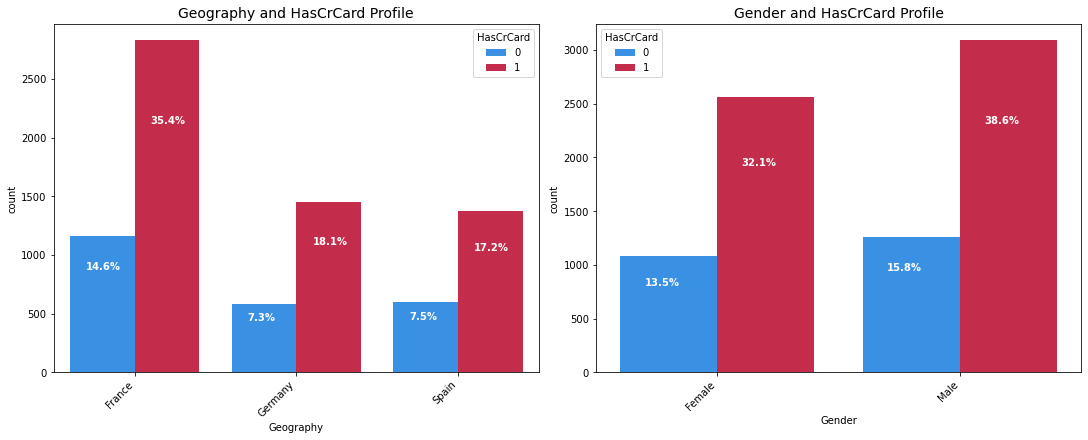

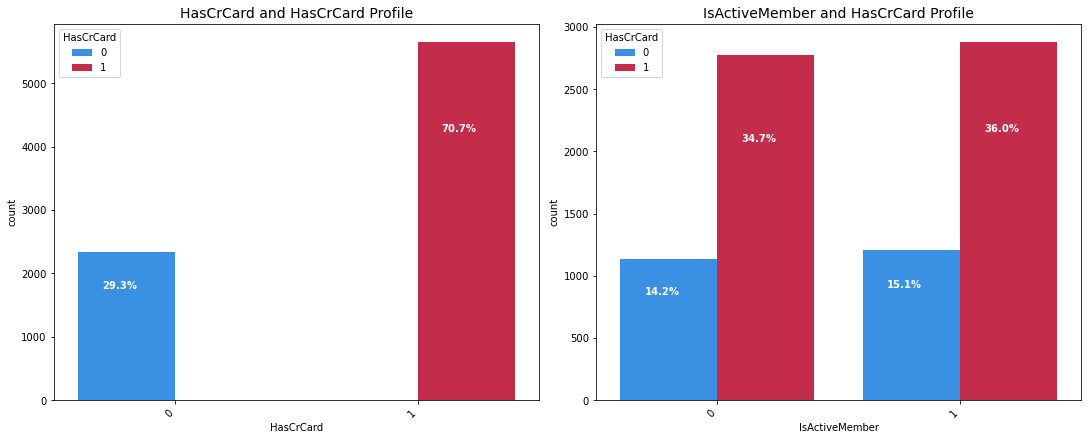

In [19]:
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "HasCrCard",
    color_palette = default_color_palette,
    df            = x_train)

### Observations based on Active Status
- Same observation as in above,
- The propotion of active vs none active members is the same throughout all the countries,
- The bank as more active members who own credit cards.

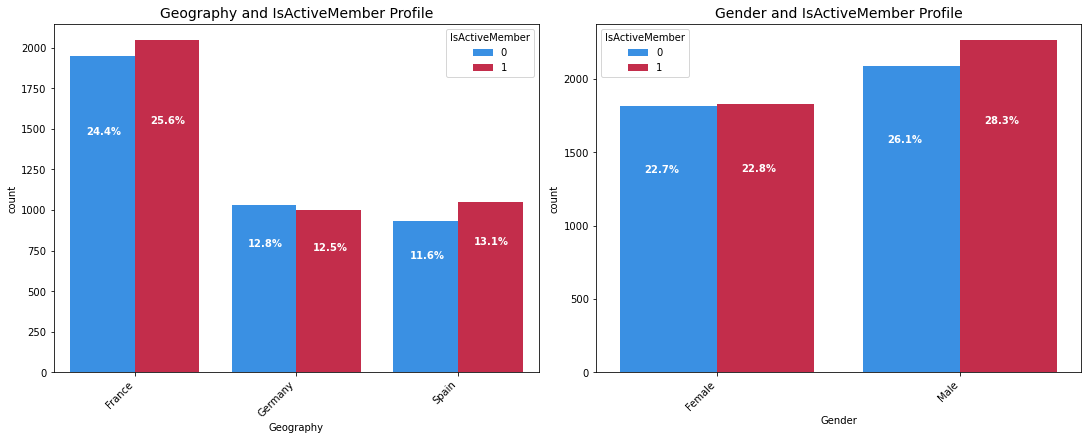

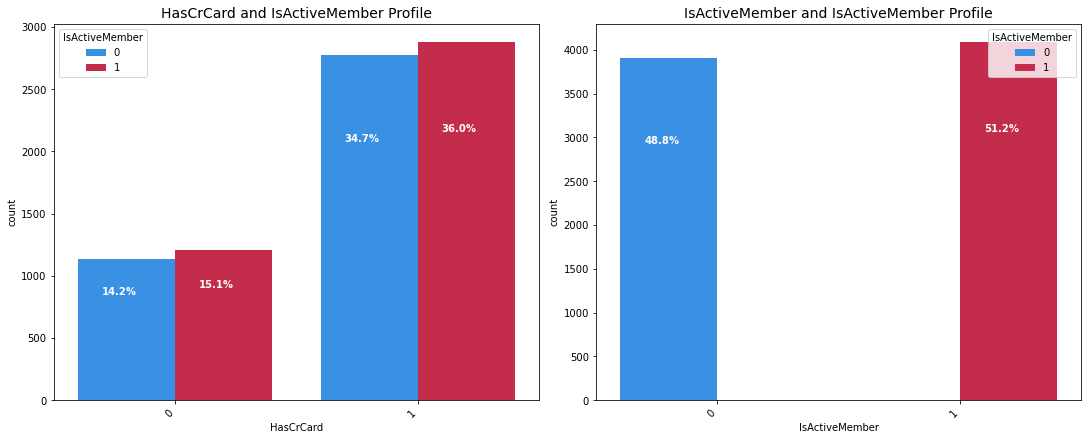

In [20]:
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "IsActiveMember",
    color_palette = default_color_palette,
    df            = x_train)

In [21]:
'''
Input:
N/A

Output:
Plot box plots in line.

Returns:
N/A
'''     
def BoxPlotsUnivariateAnalysis(col_names, hue_name, color_palette, X, Y):
    df = pd.concat([X, Y], axis=1)
    print(col_names)
    col_index = 0
    for r in range(0, int(len(col_names)), 2):
        fig, axs = plt.subplots(
            nrows=1,                                                                # Number of rows of the grid
            ncols=2,                                                                # Number of columns of the grid.
            figsize=(15,6),
            constrained_layout=True)
        
        for ax in axs.reshape(-1):
            ax = sns.boxplot(
                data    = df, 
                x       = col_names[col_index],
                y       = TARGET_COLUMN,
                hue     = hue_name,
                orient  = "h",
                palette = color_palette,
                ax      = ax)
            ax.set_xlabel(col_names[col_index])
            ax.legend(loc='upper right')
            ax.set_title(col_names[col_index] +' VS. '+hue_name+ ' Profile', fontsize=14)
            col_index += 1

### Observations based on Gender
- Majority of the customers have a relatively good credit score.
- Theres more customers in the age range (40,50) who have exited.
- More male customers with a balance > 50000 have exited.

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


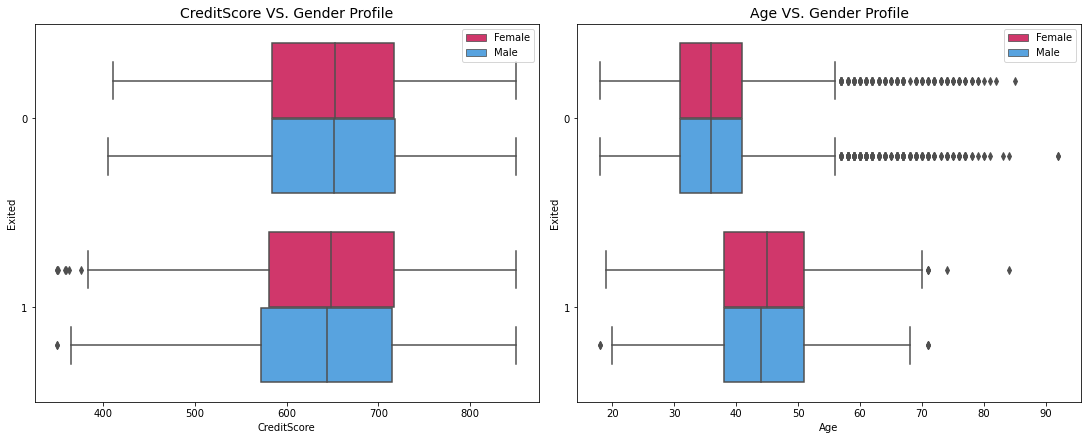

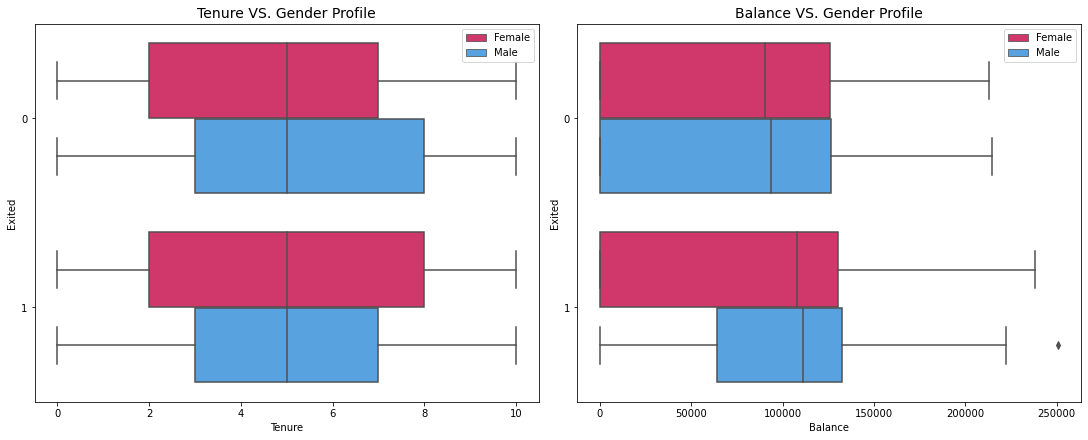

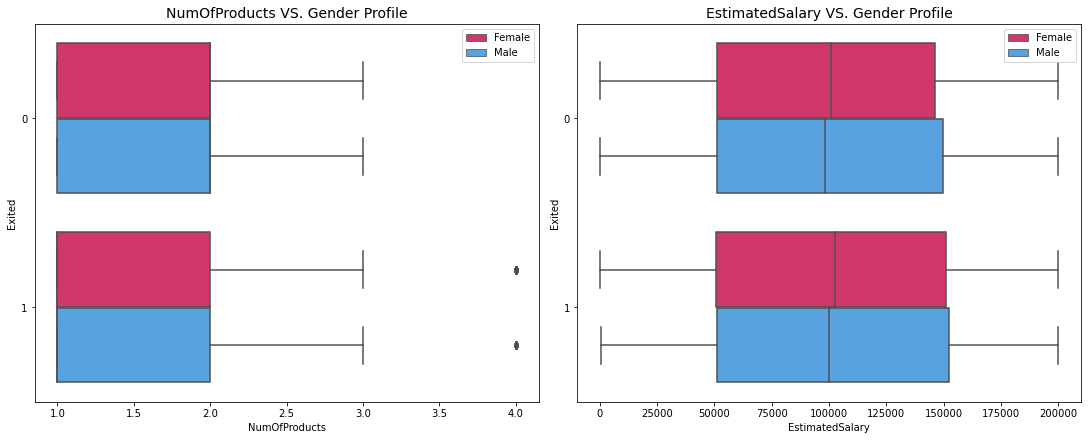

In [22]:
number_cols = x_train.select_dtypes(include=['float', 'int64',  'uint8']).columns.tolist()

BoxPlotsUnivariateAnalysis(
    col_names       = number_cols,
    hue_name        = "Gender",
    color_palette   = gender_color_palette,
    X               = x_train,
    Y               = y_train)

### Observations based on Geography
- same as above

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


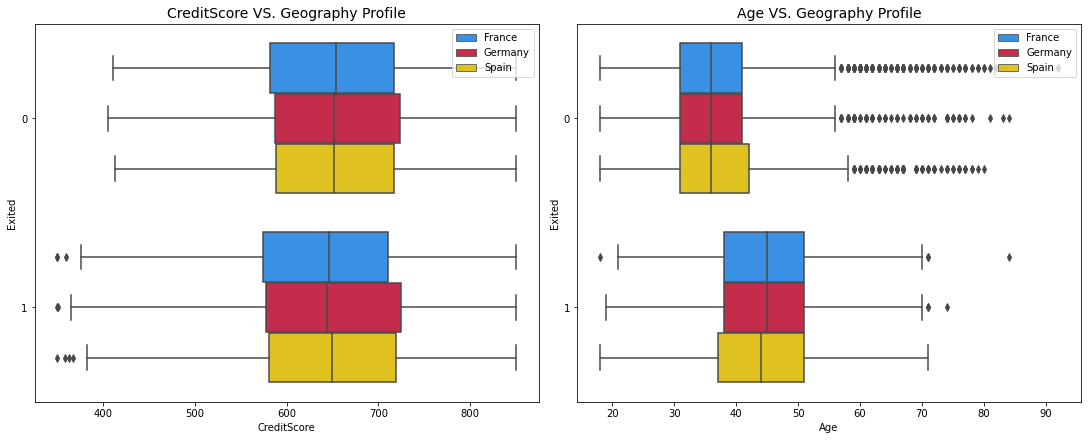

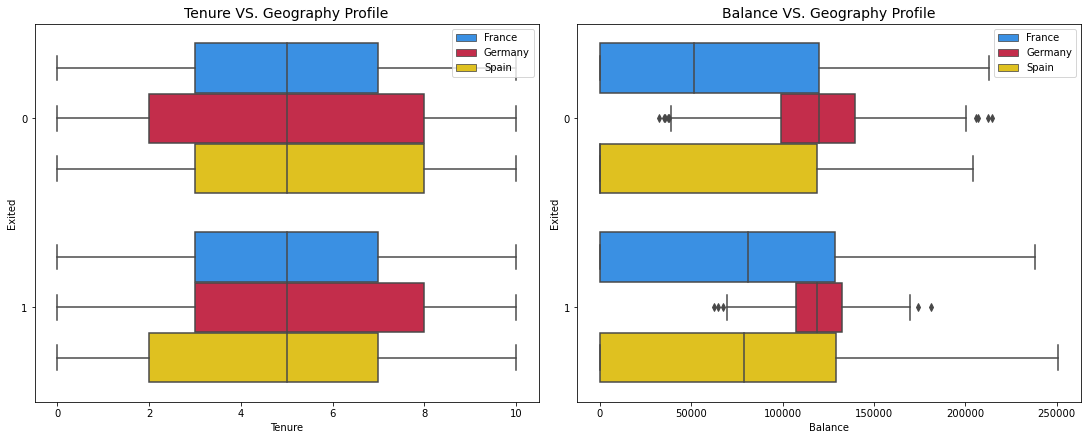

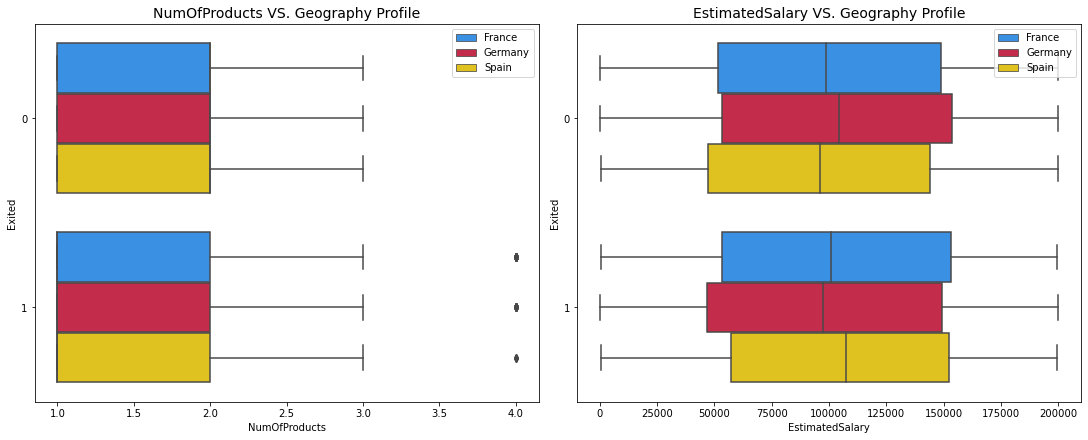

In [23]:
BoxPlotsUnivariateAnalysis(
    col_names       = number_cols,
    hue_name        = "Geography",
    color_palette   = default_color_palette,
    X               = x_train,
    Y               = y_train)

### Observations based on Credit Card Status
- A slightly more older customers who have a credit card have exited.

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


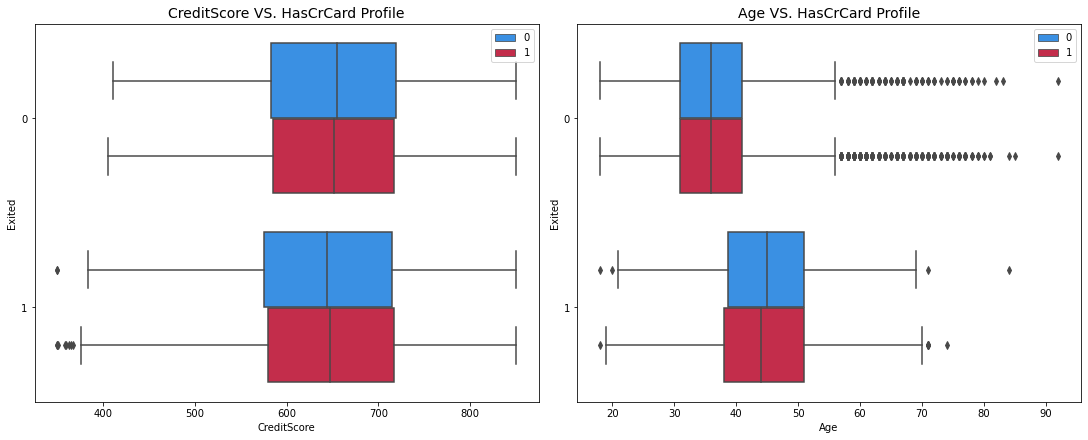

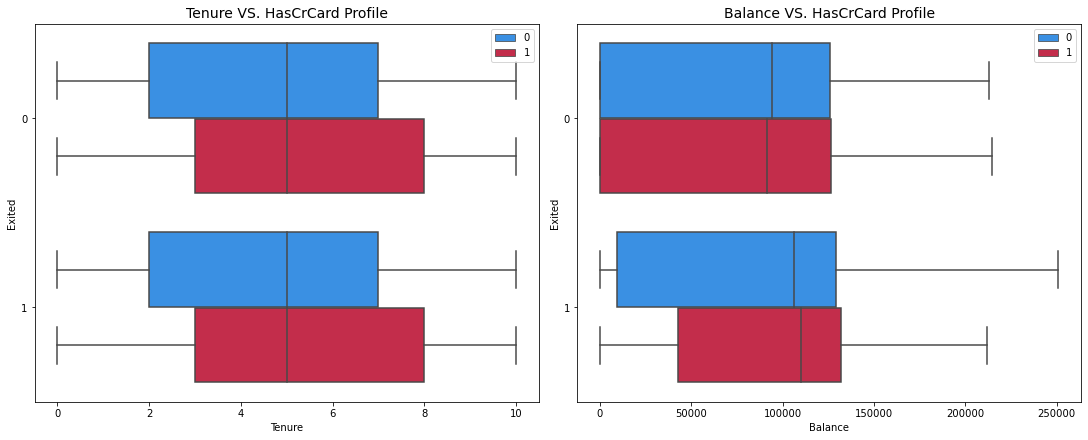

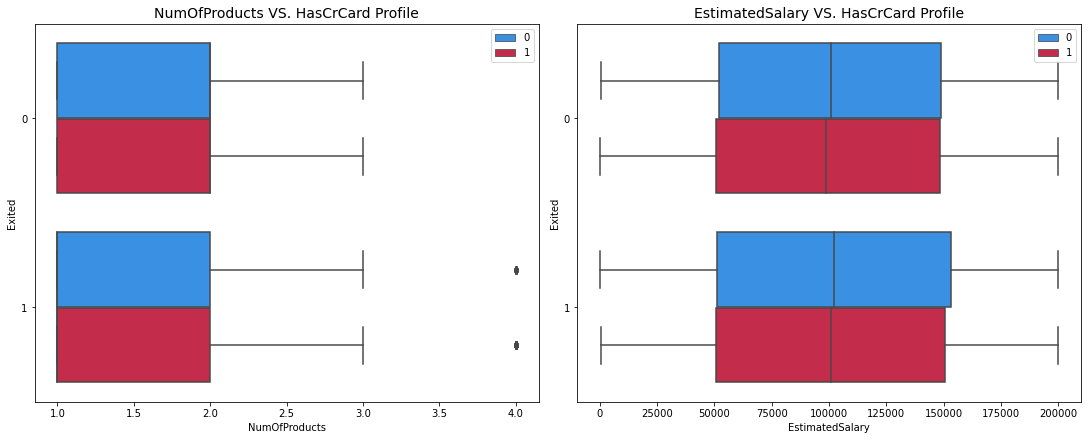

In [24]:
BoxPlotsUnivariateAnalysis(
    col_names     = number_cols,
    hue_name      = "HasCrCard",
    color_palette = default_color_palette,
    X             = x_train,
    Y             = y_train)

### Observations based on Active Status
- A slightly more older customers who have a credit card have exited.

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


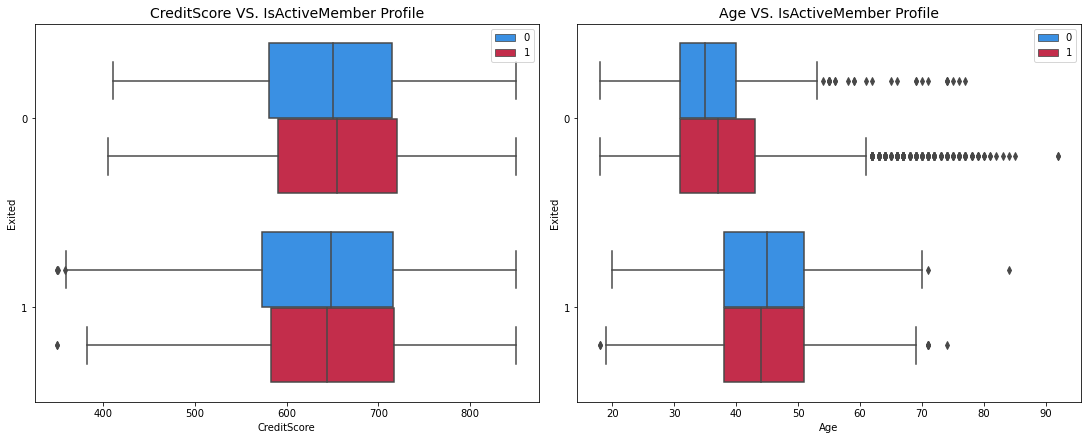

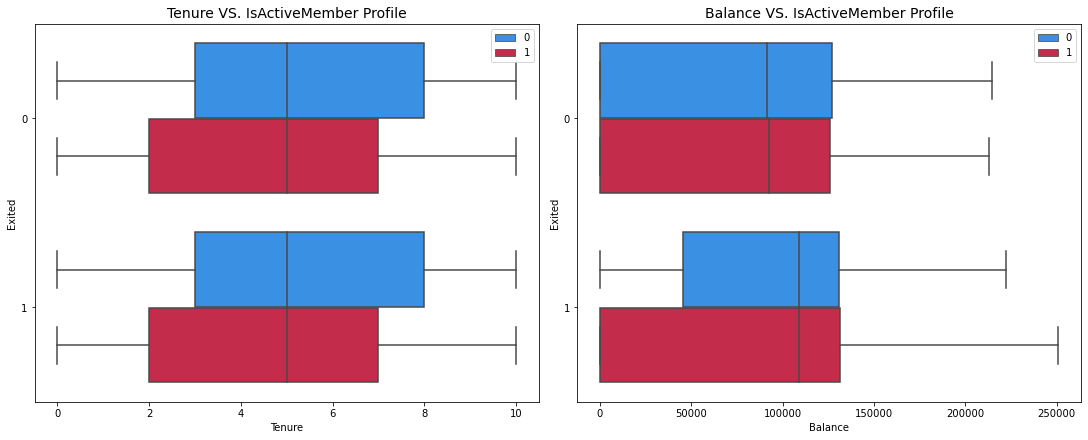

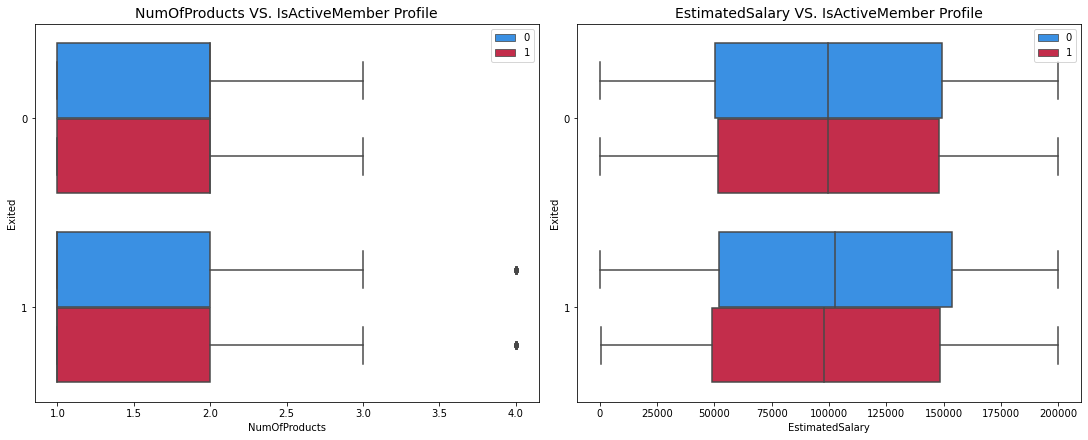

In [25]:
BoxPlotsUnivariateAnalysis(
    col_names     = number_cols,
    hue_name      = "IsActiveMember",
    color_palette = default_color_palette,
    X             = x_train,
    Y             = y_train)

## Multivariate Analysis

In [26]:
df = pd.concat([x_train, y_train], axis=1)

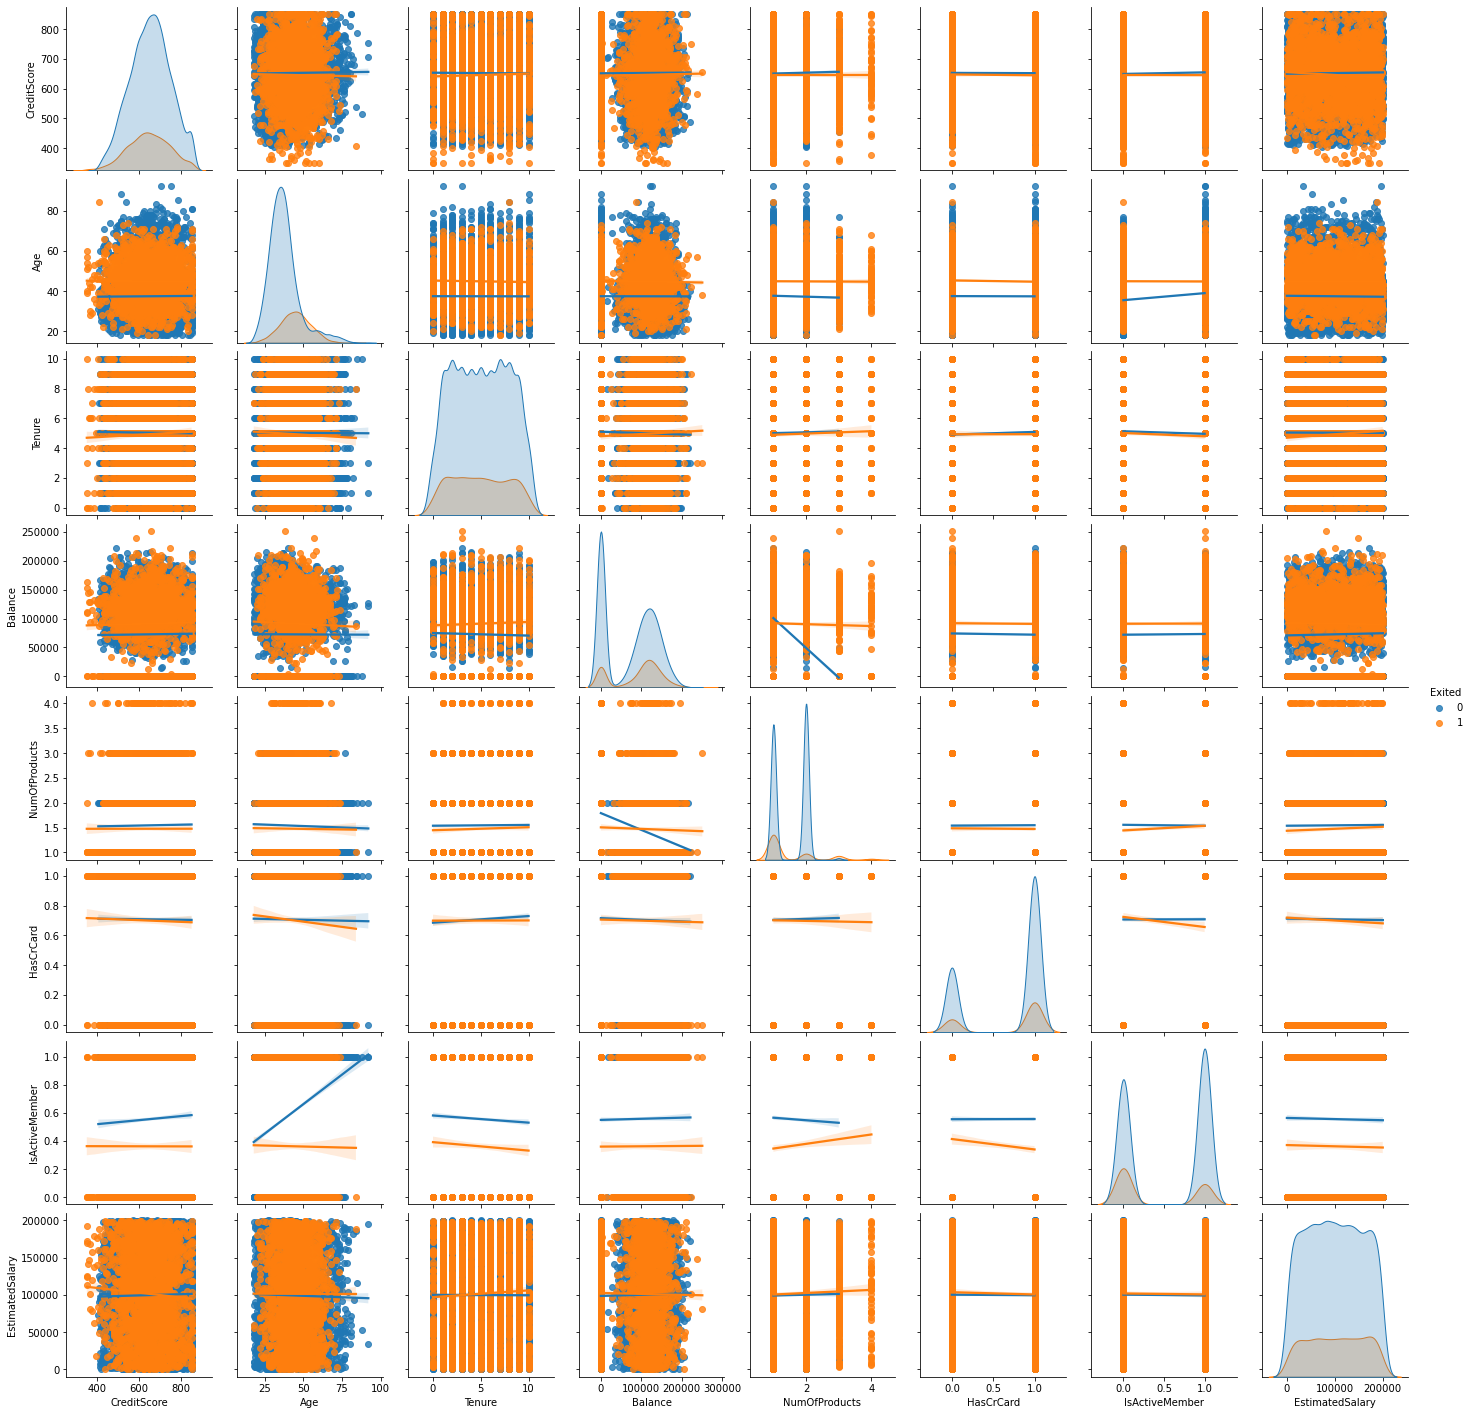

In [27]:
sns.pairplot(main_data, kind="reg", hue=TARGET_COLUMN)

### Observations

- We start to see a differentiation in the scatter plot for age > 60 and < 25 customers in these age ranges tend to stay with the bank and customers out of those ranges tend to leave.

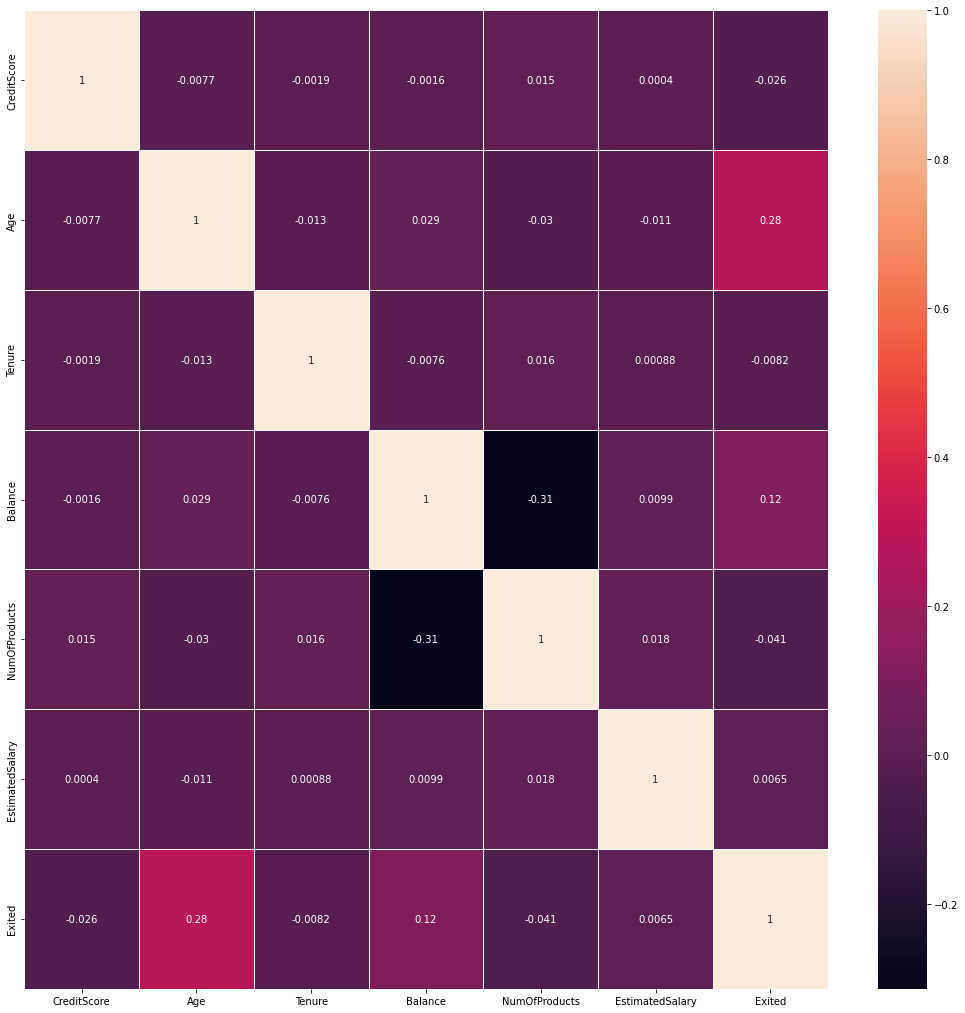

In [28]:
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(data=df.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

### Obeservations

- Theres a higer positive corrolation bewtween age and the number of customers who left the bank.
- The second highest positive corrolation with the target feature is with the Balance feature. 
- The tenure and the estimated salary features seems to have a very low corolation.

In [29]:
'''
Input:
Axis, column name/x-axis, hue name

Output:
Displays a count plot.

Retunrs:
N/A
''' 
def HistBoxplot(box_chart_ax, hist_chart_ax, x_axis, df):
    sns.boxplot(
        data=df,
        x=df[x_axis],
        showmeans=True,
        ax=box_chart_ax)
    
    sns.histplot(
        data=df,
        x=df[x_axis],
        kde=True,
        ax=hist_chart_ax)
    
    hist_chart_ax.axvline(df[x_axis].mean(),                 # Get the mean of the values in the given column and draw a vertical line that cuts the chart on the mean value 
               color=stats_colors['Mean'],                   # Use on of the colors predefined on this notebook
               label='Mean',                                 # Set the label to be diplayed on the legend
               linestyle="dashed");                          # Make the line have dashes
    
    hist_chart_ax.axvline(df[x_axis].median(),               # Plot the median line on the chart.
               color=stats_colors['Median'],                 # Use on of the colors predefined on this notebook
               label='Median',                               # Set the label to be diplayed on the legend
               linestyle="dashed");                          # Make the line have dashes
    
    hist_chart_ax.axvline(df[x_axis].mode()[0],              # Plot the mode line on the chart.
               color=stats_colors['Mode'],                   # Use on of the colors predefined on this notebook 
               label='Mode',                                 # Set the label to be diplayed on the legend
               linestyle="dashed");                          # Make the line have dashes
    
    hist_chart_ax.legend(loc='upper right')

'''
Input:
N/A

Output:
Displays a a grid of [Boxplot x Distribution chart] for discrete features.

Returns:
N/A
''' 
def PlotHistBoxGrid(df):
    col_names = df.select_dtypes(include=['float', 'int64', 'uint8']).columns.tolist()
    print(col_names)

    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, (box, hist) = plt.subplots(
            nrows=2,                                         # Number of rows of the grid
            ncols=3,                                         # Number of columns of the grid.
            figsize=(15,4),
            gridspec_kw={"height_ratios" : (0.25,0.5)},
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                HistBoxplot(box.flat[index], hist.flat[index], col_names[col_index], df)
            col_index += 1

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited']


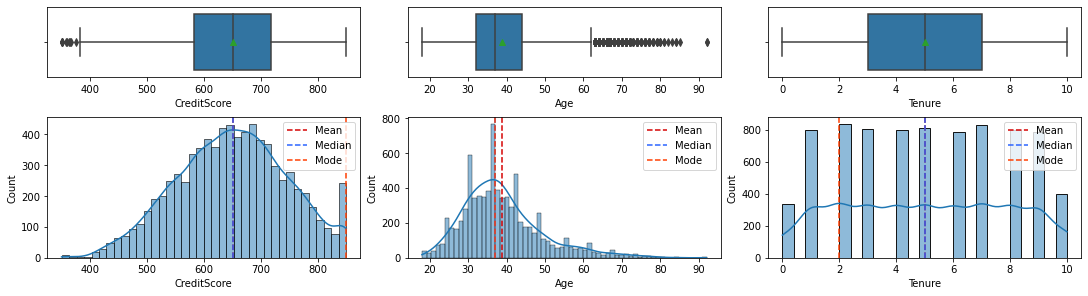

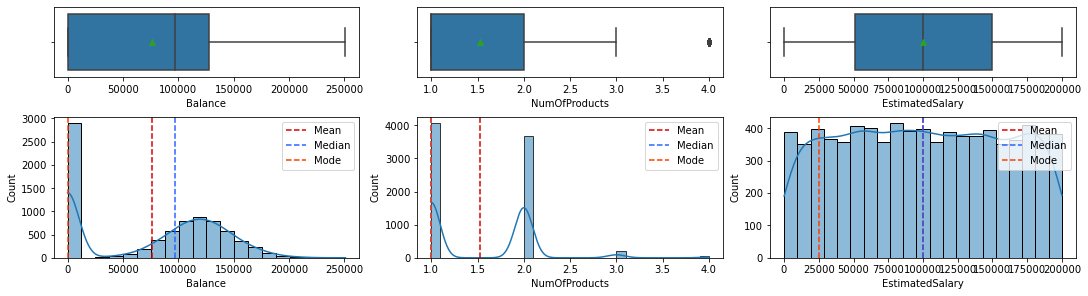

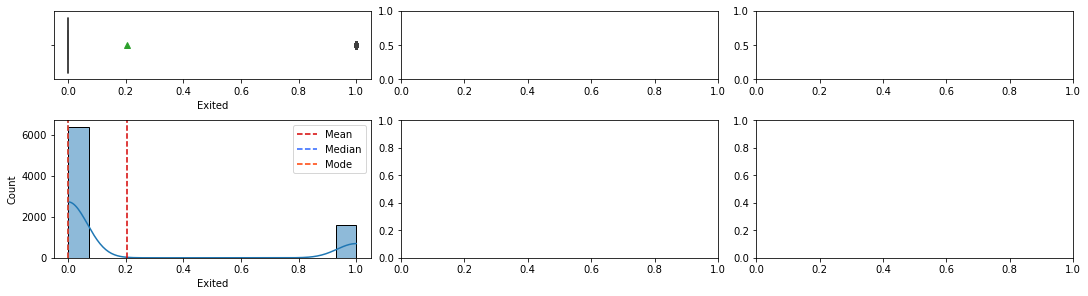

In [30]:
PlotHistBoxGrid(df)

# Data Transformation and Feature Engineering

In [31]:
x_train.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82


## Encode Categorial Variables

In [32]:
def OneHotEncoding(data):
    oneHotCols = ["Geography", "Gender"]
    data['x_train'] = pd.get_dummies(data['x_train'], columns=oneHotCols)
    data['x_test']  = pd.get_dummies(data['x_test'], columns=oneHotCols)
    return data

model_data = OneHotEncoding(model_data)
x_train.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82


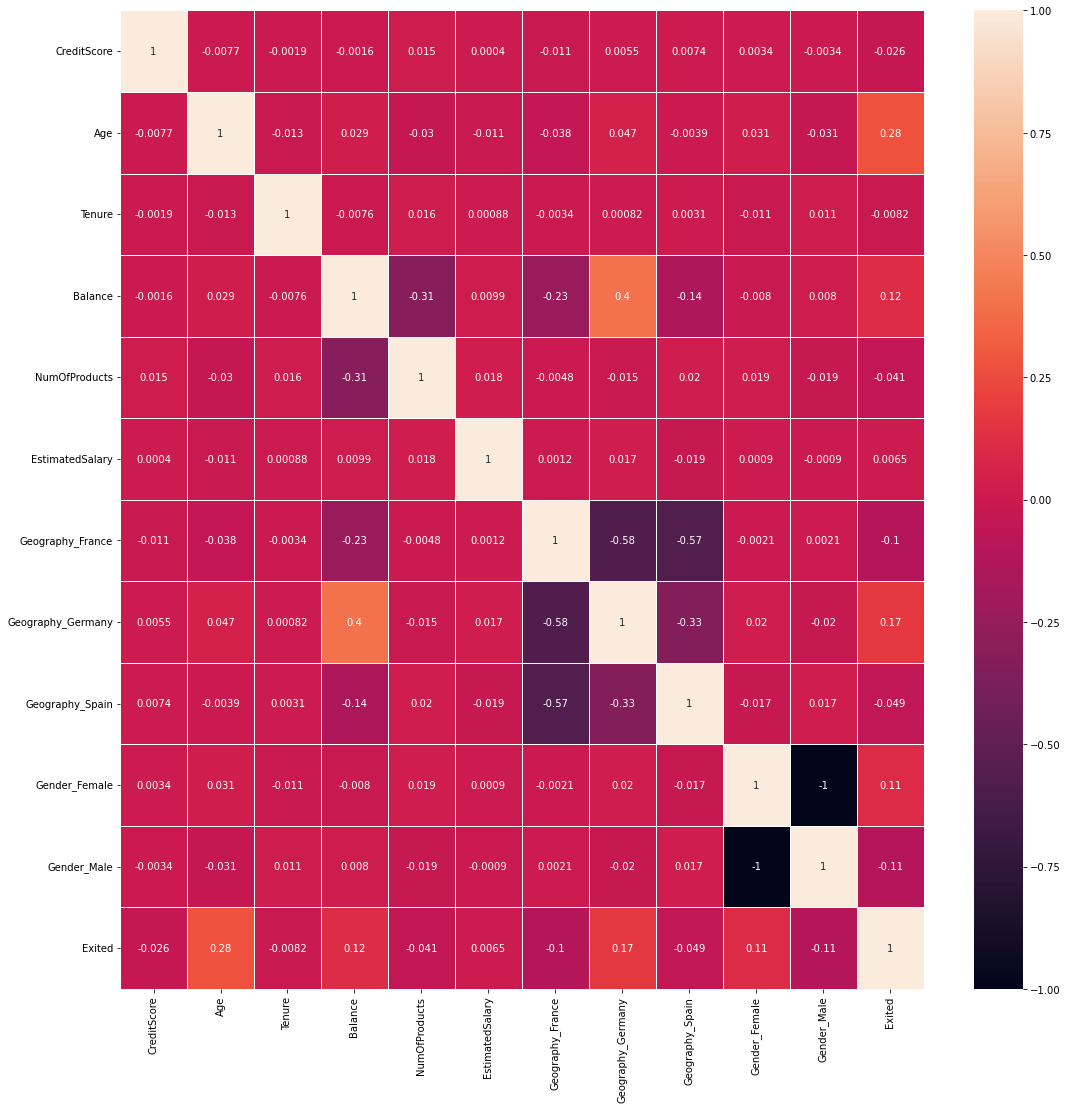

In [33]:
df = pd.concat([model_data['x_train'], model_data['y_train']], axis=1)
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(data=df.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

### Observations
- Customers in France are less likely to leave the bank
- Customers in Gemerny are slightly more likely to leave the bank.
- Male customers are slighly more likely to leave the bank compared to Female customers
- There is very low corrolation for tenuer and estimated salary to the target variable.

## Scale The Data

In [34]:

def Rescale(data):
    standard_scaler = StandardScaler()
    standard_scaler_y = StandardScaler()
    data['x_train']   = standard_scaler.fit_transform(data['x_train'])
    data['x_test']    = standard_scaler.fit_transform(data['x_test'])
    return data
    
model_data = Rescale(model_data)  
model_data

{'x_train': array([[-0.23082038, -0.94449979, -0.70174202, ..., -0.57273139,
         -0.91509065,  0.91509065],
        [-0.25150912, -0.94449979, -0.35520275, ..., -0.57273139,
          1.09278791, -1.09278791],
        [-0.3963303 ,  0.77498705,  0.33787579, ..., -0.57273139,
          1.09278791, -1.09278791],
        ...,
        [ 0.22433188,  0.58393295,  1.3774936 , ..., -0.57273139,
          1.09278791, -1.09278791],
        [ 0.13123255,  0.01077067,  1.03095433, ..., -0.57273139,
          1.09278791, -1.09278791],
        [ 1.1656695 ,  0.29735181,  0.33787579, ..., -0.57273139,
         -0.91509065,  0.91509065]]),
 'y_train': 2694    0
 5140    0
 2568    1
 3671    0
 7427    0
        ..
 2895    0
 7813    1
 905     1
 5192    0
 235     1
 Name: Exited, Length: 8000, dtype: int64,
 'x_test': array([[-1.05008411,  0.75175306, -1.01618321, ..., -0.57812007,
         -0.90179633,  0.90179633],
        [ 0.29631699, -0.47907689, -0.67334137, ..., -0.57812007,
         

# Model Training and Evaluation

## Build Model With All Random Initialization Techniques

In [35]:
model_data['x_train'].shape

(8000, 13)

In [36]:
def GetBaseModel(current_optimiser, data, hidden_layer_activation, output_layer_activation, loss_metric, scores, initializer='random_normal'):
    backend.clear_session()
    sequential_model = keras.Sequential()
    sequential_model.add(Dense(64, activation=hidden_layer_activation,kernel_initializer=initializer, input_dim=data['x_train'].shape[1]))
    sequential_model.add(Dropout(0.3))
    sequential_model.add(Dense(32, activation=hidden_layer_activation, kernel_initializer=initializer))
    sequential_model.add(Dropout(0.3))
    sequential_model.add(Dense(16, activation=hidden_layer_activation, kernel_initializer=initializer))
    sequential_model.add(BatchNormalization())
    sequential_model.add(Dense(8, activation=hidden_layer_activation, kernel_initializer=initializer))
    sequential_model.add(BatchNormalization())
    sequential_model.add(Dense(1, activation=output_layer_activation, kernel_initializer=initializer))
    sequential_model.summary()

    sequential_model.compile(
        loss=loss_metric,
        optimizer=current_optimiser,
        metrics=['accuracy', 'FalsePositives', 'TruePositives', 'Recall'])

    history=sequential_model.fit(
        model_data['x_train'],
        model_data['y_train'],
        epochs=50,
        validation_split=0.2,
        verbose=0)
    history = pd.DataFrame.from_dict(history.history)
    history_stats = history.describe().T
    
    scores["Hidden Layer Activation"].append(hidden_layer_activation)
    scores["Output Layer Activation"].append(output_layer_activation)
    scores["Max Accuracy Train"].append(history_stats.loc['accuracy']['max'])
    scores["Max Accuracy Test"].append(history_stats.loc['val_accuracy']['max'])
    scores["Max Recall Train"].append(history_stats.loc['recall']['max'])
    scores["Max Recall Test"].append(history_stats.loc['val_recall']['max'])
    scores["Weight Initialisation"].append(initializer)
    scores["Loss"].append("binary_crossentropy")
    
    return {
        'Model'   : sequential_model,
        'History' : history,
        "Stats"   : scores
    }

def Scores(dic):
    return pd.DataFrame.from_dict(dic).T

def GetModelPredictions(model, data):
    y_pred = model.predict(data['x_test'])
    y_pred = np.round(y_pred,0)
    print(classification_report(data['y_test'],y_pred))
    return y_pred

def DisplayConfusionMatrix(y_actual, y_predict, matix_title, labels=[1,0]):
    conf_matrix = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    confusion_matix_df = pd.DataFrame(
        conf_matrix,
        index   = [i for i in ["Actual No", "Actual Yes"]],
        columns = [i for i in ["Predicted - No", "Predicted - Yes"]])
    
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percetages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percetages)]
    labels = np.array(labels).reshape(2, 2)
    plt.figure(figsize= (15,9))
    sns.heatmap(confusion_matix_df, annot=labels,fmt='')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(f'Confusion Matrix for : {matix_title}')
    
def ShowModelStats(history, actual_y, predictions_y, label):
    # chart 0
    DisplayConfusionMatrix(actual_y, predictions_y, label, labels=[1,0], )
    
    # chart 1
    plt.figure(figsize= (15,9))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accurracy Summary: {label}')
    plt.ylabel('Score')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='best')
    plt.show()
    
    # chart 2
    plt.figure(figsize= (15,9))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Model Loss Summary: {label}')
    plt.ylabel('Score')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()

    # chart 3
    plt.figure(figsize= (15,9))
    auc_score = roc_auc_score(actual_y, predictions_y)
    print('ROC AUC=%.3f' % (auc_score))
    false_pos_random, true_pos_random, _ = roc_curve(actual_y, [0 for _ in range(len(actual_y))])
    false_pos, true_pos, _ = roc_curve(actual_y, predictions_y)
    pyplot.plot(false_pos_random, true_pos_random, linestyle='--', label='Random Classifier')
    pyplot.plot(false_pos, true_pos, marker='.', label='Neural Network Model')
    pyplot.title(f'ROC-AUC: {label}')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    
def GetModelStats(model):
    evaluation_history = model['History']
    return evaluation_history.describe()

In [37]:
model_evaluation_scores = {
    "Hidden Layer Activation" : [],
    "Output Layer Activation" : [],
    "Loss"                    : [],
    "Weight Initialisation"   : [],
    "Max Accuracy Train"      : [],
    "Max Accuracy Test"       : [],
    "Max Recall Train"        : [],
    "Max Recall Test"         : []
}

### Random Normal Initialization

In [38]:
random_seed = 35
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [39]:
model_1 = GetBaseModel(
    current_optimiser       = optimizers.Adam(lr=1e-3),
    data                    = model_data,
    hidden_layer_activation = 'relu',
    output_layer_activation = 'sigmoid',
    loss_metric             = losses.binary_crossentropy,
    scores                  = model_evaluation_scores)
model_evaluation_scores = model_1['Stats']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                        

2022-04-09 06:55:51.245667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
model_1['History'].describe().T

,count,mean,std,min,25%,50%,75%,max
loss,50.0,0.354732,0.041113,0.329932,0.337375,0.344607,0.355195,0.601983
accuracy,50.0,0.856150,0.018309,0.741406,0.854766,0.861094,0.863711,0.867031
false_positives,50.0,205.720000,129.070150,160.000000,170.500000,181.000000,194.750000,1065.000000
true_positives,50.0,583.080000,34.556573,500.000000,570.000000,591.500000,602.500000,708.000000
recall,50.0,0.449214,0.026623,0.385208,0.439137,0.455701,0.464176,0.545455
val_loss,50.0,0.358111,0.034775,0.341792,0.348870,0.350954,0.353397,0.571328
val_accuracy,50.0,0.847438,0.009113,0.797500,0.846875,0.848750,0.850625,0.855625
val_false_positives,50.0,36.260000,11.545491,0.000000,32.250000,38.000000,43.000000,55.000000
val_true_positives,50.0,116.160000,23.705127,0.000000,112.250000,121.000000,127.000000,139.000000
val_recall,50.0,0.358519,0.073164,0.000000,0.346451,0.373457,0.391975,0.429012


In [41]:
y_predictions = GetModelPredictions(model_1['Model'], model_data)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1585
           1       0.84      0.40      0.54       415

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000



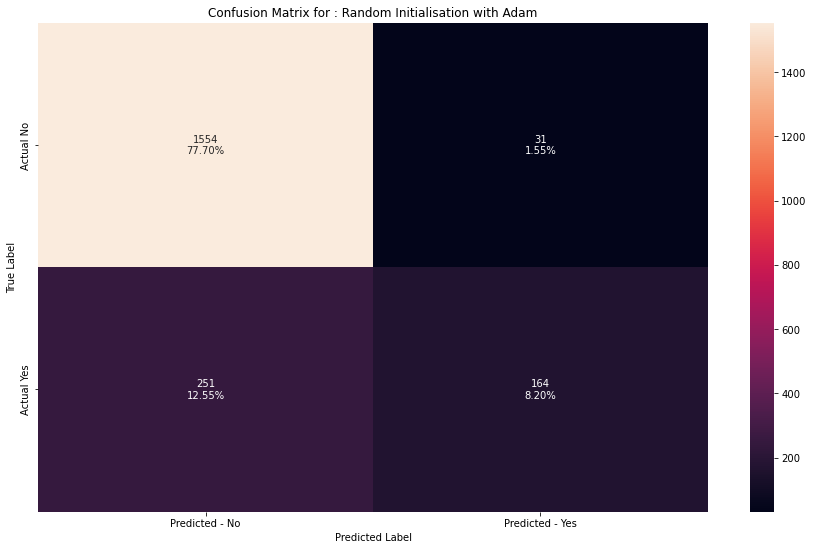

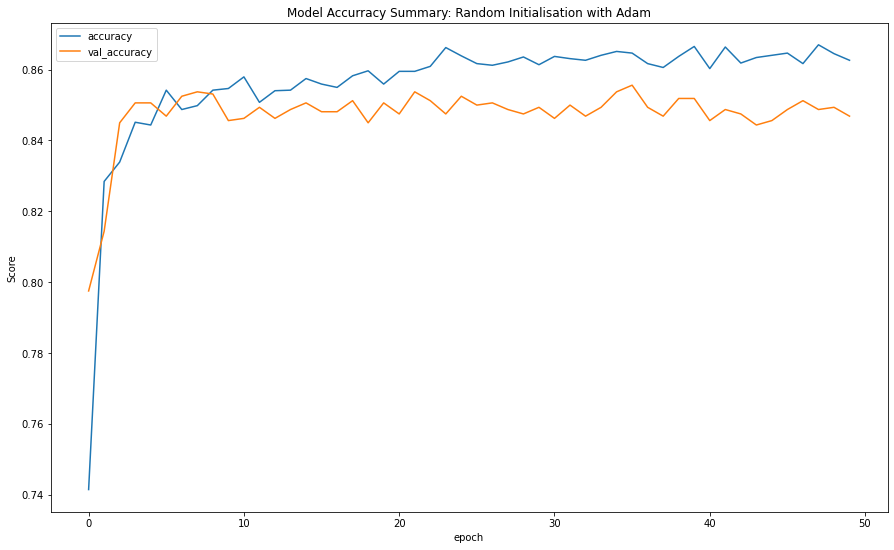

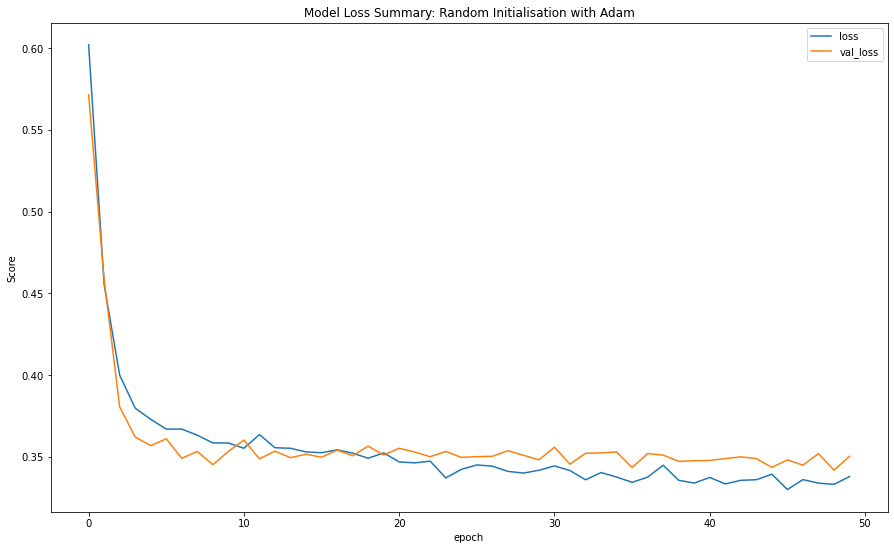

ROC AUC=0.688


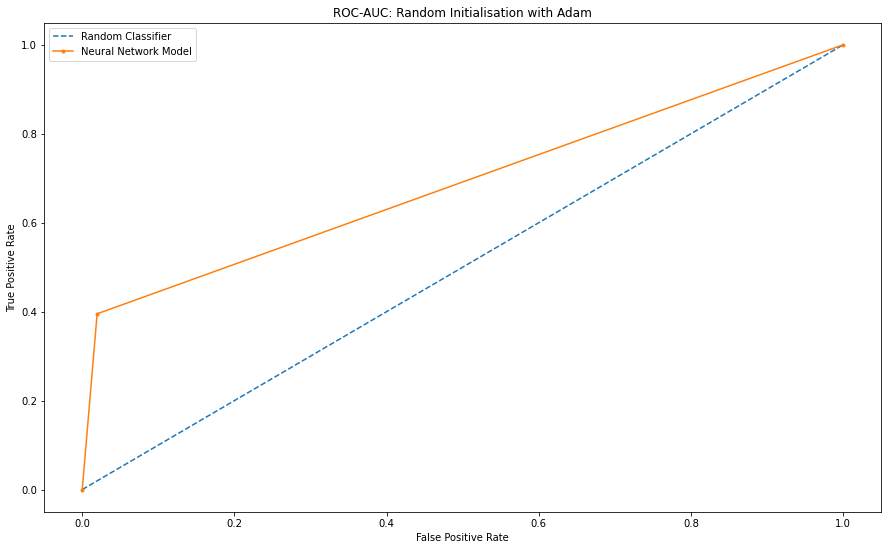

In [42]:
ShowModelStats(
    history       = model_1['History'],
    actual_y      = model_data['y_test'],
    predictions_y = y_predictions,
    label         = "Random Initialisation with Adam")

In [43]:
GetModelStats(model_1)

,loss,accuracy,false_positives,true_positives,recall,val_loss,val_accuracy,val_false_positives,val_true_positives,val_recall
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.354732,0.856150,205.72000,583.080000,0.449214,0.358111,0.847438,36.260000,116.160000,0.358519
std,0.041113,0.018309,129.07015,34.556573,0.026623,0.034775,0.009113,11.545491,23.705127,0.073164
min,0.329932,0.741406,160.00000,500.000000,0.385208,0.341792,0.797500,0.000000,0.000000,0.000000
25%,0.337375,0.854766,170.50000,570.000000,0.439137,0.348870,0.846875,32.250000,112.250000,0.346451
50%,0.344607,0.861094,181.00000,591.500000,0.455701,0.350954,0.848750,38.000000,121.000000,0.373457
75%,0.355195,0.863711,194.75000,602.500000,0.464176,0.353397,0.850625,43.000000,127.000000,0.391975
max,0.601983,0.867031,1065.00000,708.000000,0.545455,0.571328,0.855625,55.000000,139.000000,0.429012


## Observations

- The recall is too low, this may be due to the fact that the data is imbalanced as the true negatives are high and this is also reflected by the EDA.
- We can try to address this through a Bagging classifier which will servce as our Data augmentation techinuque
- We can also try out other weight initialisation methods as the accuray is at max 50%.
- Altentively we can try our grid search but there are lot of hyper parameters to search for and this would take a very long time and will be left out for the purposes of this assignment.

## HE Weight Initialization

In [44]:
model_2 = GetBaseModel(
    current_optimiser       = optimizers.Adam(lr=1e-3),
    data                    = model_data,
    hidden_layer_activation = 'relu',
    output_layer_activation = 'sigmoid',
    loss_metric             = losses.binary_crossentropy,
    scores                  = model_evaluation_scores,
    initializer             = "HeNormal")
model_evaluation_scores = model_2['Stats']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                        

In [45]:
model_2['History'].describe().T

,count,mean,std,min,25%,50%,75%,max
loss,50.0,0.394582,0.056740,0.344099,0.359843,0.374626,0.408871,0.680021
accuracy,50.0,0.832275,0.034176,0.640938,0.823672,0.843828,0.852539,0.857969
false_positives,50.0,219.580000,165.618087,90.000000,192.250000,207.000000,215.750000,1348.000000
true_positives,50.0,444.140000,152.231967,52.000000,368.000000,511.500000,554.750000,603.000000
recall,50.0,0.342173,0.117282,0.040062,0.283513,0.394068,0.427388,0.464561
val_loss,50.0,0.368219,0.036227,0.341558,0.345894,0.350027,0.373802,0.500691
val_accuracy,50.0,0.843100,0.015924,0.797500,0.840937,0.850000,0.852344,0.854375
val_false_positives,50.0,25.000000,12.227437,0.000000,17.000000,26.000000,35.000000,43.000000
val_true_positives,50.0,97.960000,35.952327,0.000000,88.500000,112.500000,124.000000,130.000000
val_recall,50.0,0.302346,0.110964,0.000000,0.273148,0.347222,0.382716,0.401235


In [46]:
y_predictions = GetModelPredictions(model_2['Model'], model_data)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1585
           1       0.82      0.44      0.57       415

    accuracy                           0.86      2000
   macro avg       0.84      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000



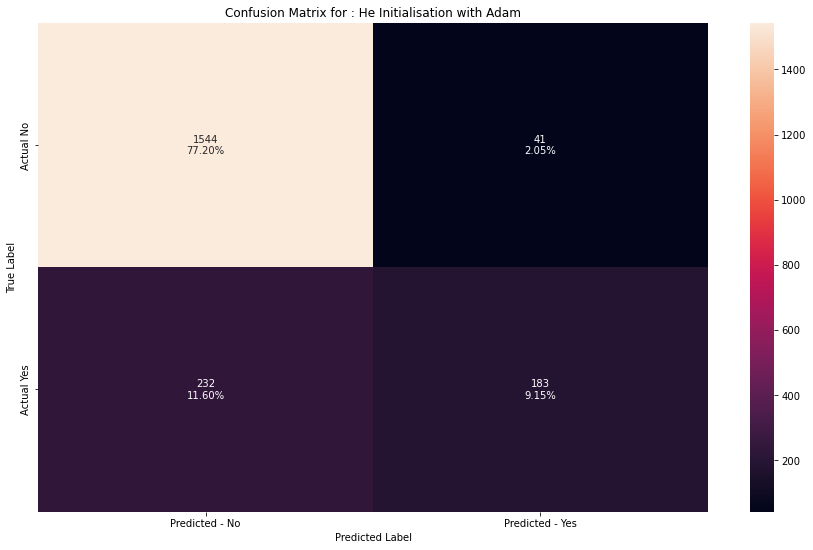

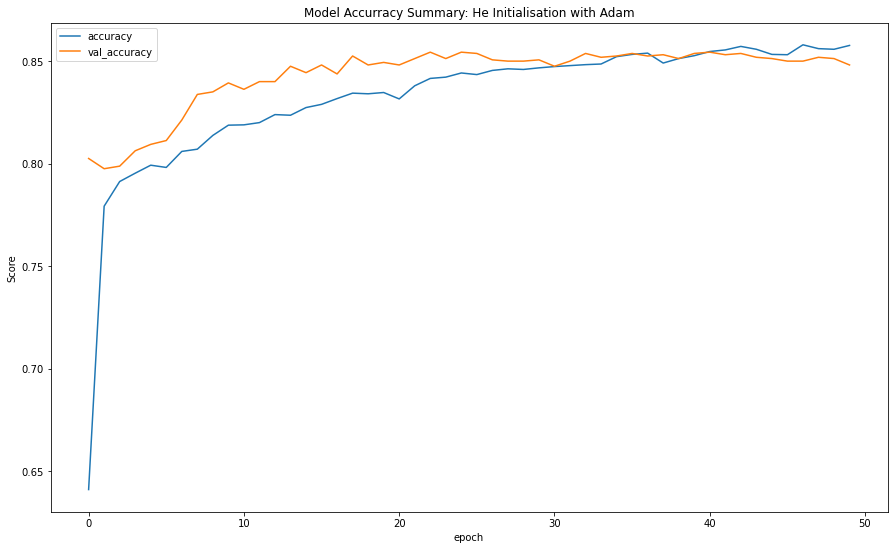

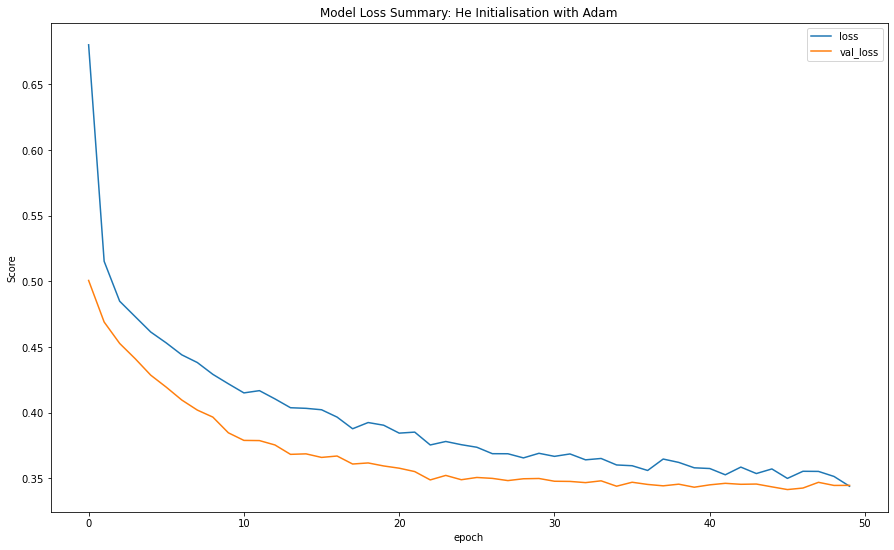

ROC AUC=0.708


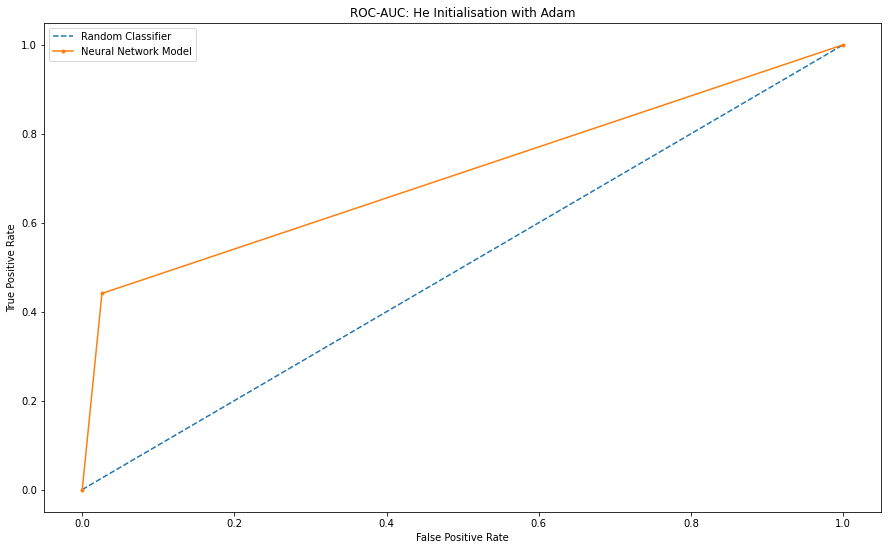

In [47]:
ShowModelStats(
    history       = model_2['History'],
    actual_y      = model_data['y_test'],
    predictions_y = y_predictions,
    label         = "He Initialisation with Adam")

In [48]:
GetModelStats(model_2)

,loss,accuracy,false_positives,true_positives,recall,val_loss,val_accuracy,val_false_positives,val_true_positives,val_recall
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.394582,0.832275,219.580000,444.140000,0.342173,0.368219,0.843100,25.000000,97.960000,0.302346
std,0.056740,0.034176,165.618087,152.231967,0.117282,0.036227,0.015924,12.227437,35.952327,0.110964
min,0.344099,0.640938,90.000000,52.000000,0.040062,0.341558,0.797500,0.000000,0.000000,0.000000
25%,0.359843,0.823672,192.250000,368.000000,0.283513,0.345894,0.840937,17.000000,88.500000,0.273148
50%,0.374626,0.843828,207.000000,511.500000,0.394068,0.350027,0.850000,26.000000,112.500000,0.347222
75%,0.408871,0.852539,215.750000,554.750000,0.427388,0.373802,0.852344,35.000000,124.000000,0.382716
max,0.680021,0.857969,1348.000000,603.000000,0.464561,0.500691,0.854375,43.000000,130.000000,0.401235


## Xavier Weight Initialization

In [49]:
model_3 = GetBaseModel(
    current_optimiser       = optimizers.Adam(lr=1e-3),
    data                    = model_data,
    hidden_layer_activation = 'relu',
    output_layer_activation = 'sigmoid',
    loss_metric             = losses.binary_crossentropy,
    scores                  = model_evaluation_scores,
    initializer             = "GlorotUniform")
model_evaluation_scores = model_3['Stats']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                        

In [50]:
model_3['History'].describe().T

,count,mean,std,min,25%,50%,75%,max
loss,50.0,0.374071,0.048126,0.342804,0.348606,0.357826,0.377321,0.634102
accuracy,50.0,0.841166,0.030169,0.666719,0.838320,0.850859,0.856328,0.862813
false_positives,50.0,242.300000,170.862787,178.000000,205.250000,218.500000,227.750000,1417.000000
true_positives,50.0,523.760000,100.444433,205.000000,510.500000,562.000000,582.000000,609.000000
recall,50.0,0.403513,0.077384,0.157935,0.393297,0.432974,0.448382,0.469183
val_loss,50.0,0.357190,0.028273,0.343849,0.346487,0.349266,0.353331,0.523608
val_accuracy,50.0,0.846038,0.010570,0.802500,0.846875,0.849375,0.851250,0.855000
val_false_positives,50.0,29.620000,12.277223,6.000000,24.000000,29.000000,36.750000,87.000000
val_true_positives,50.0,107.280000,19.839190,43.000000,102.000000,111.500000,120.500000,133.000000
val_recall,50.0,0.331111,0.061232,0.132716,0.314815,0.344136,0.371914,0.410494


In [51]:
y_predictions = GetModelPredictions(model_3['Model'], model_data)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1585
           1       0.82      0.41      0.55       415

    accuracy                           0.86      2000
   macro avg       0.84      0.70      0.73      2000
weighted avg       0.86      0.86      0.84      2000



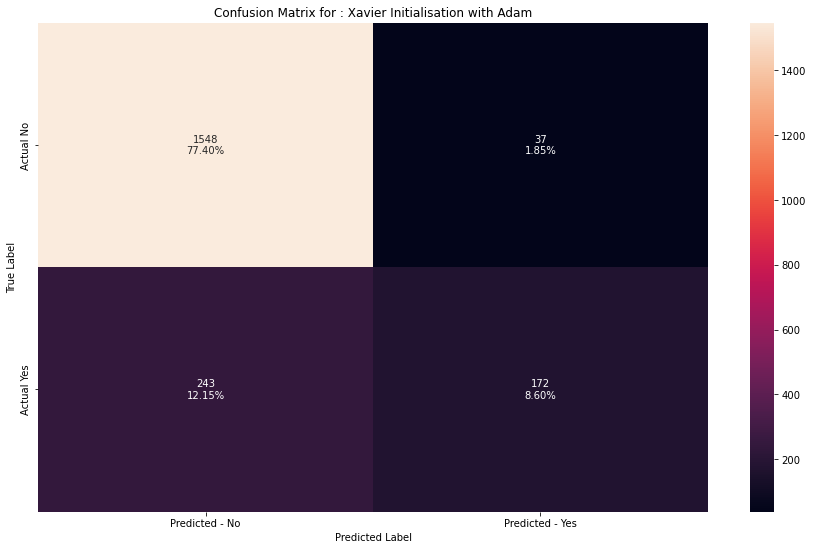

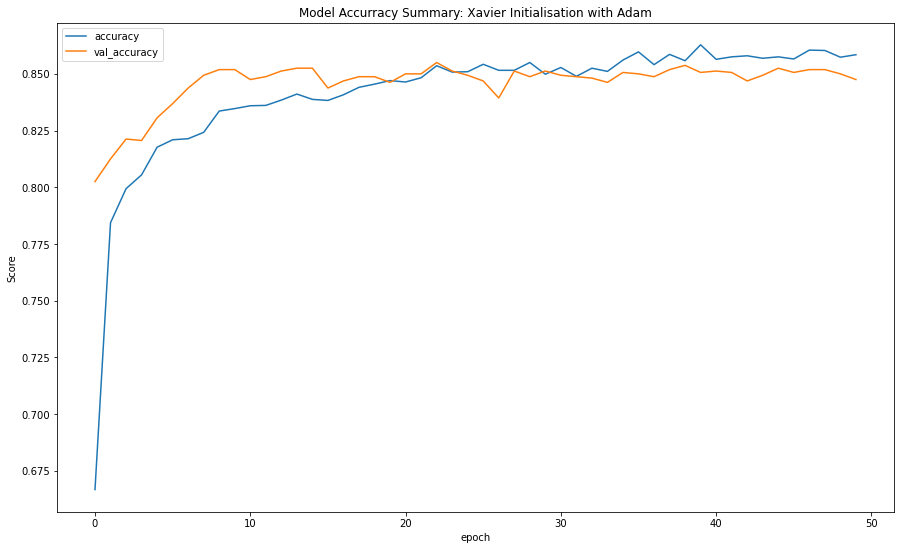

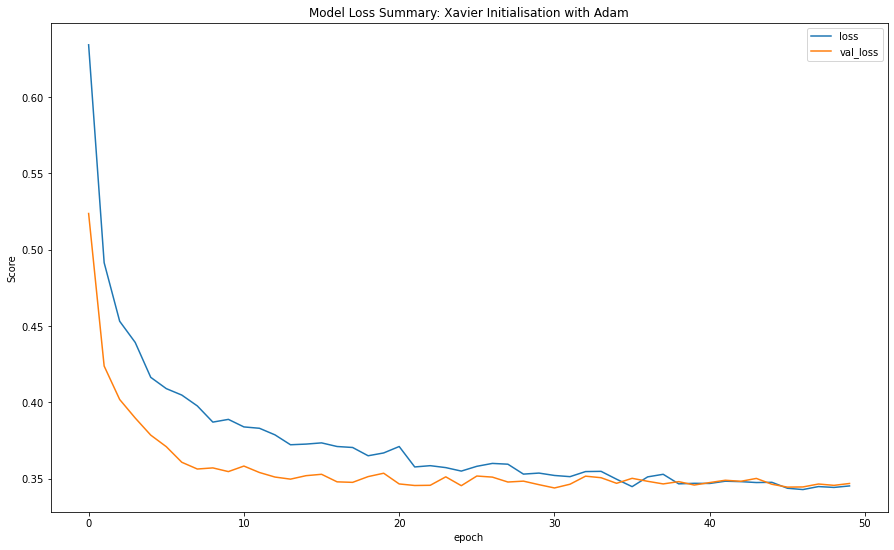

ROC AUC=0.696


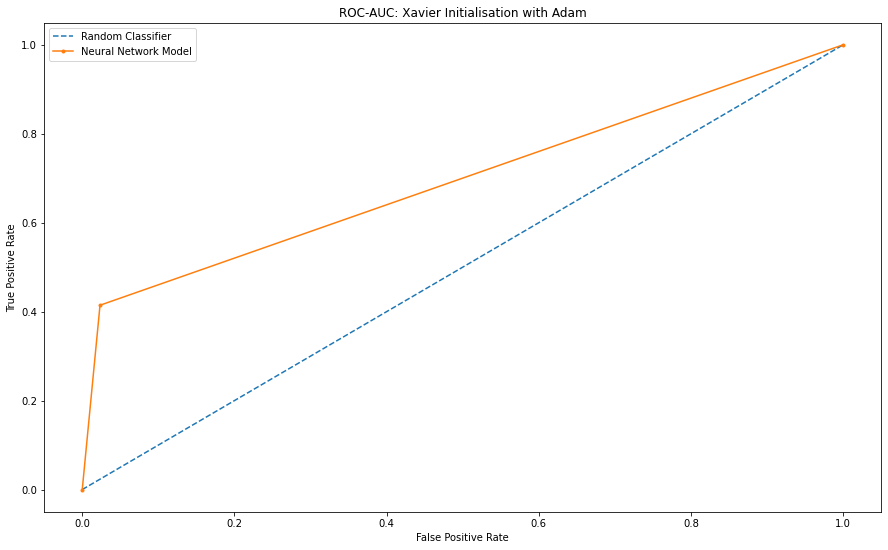

In [52]:
ShowModelStats(
    history       = model_3['History'],
    actual_y      = model_data['y_test'],
    predictions_y = y_predictions,
    label         = "Xavier Initialisation with Adam")

In [53]:
GetModelStats(model_3)

,loss,accuracy,false_positives,true_positives,recall,val_loss,val_accuracy,val_false_positives,val_true_positives,val_recall
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000
mean,0.374071,0.841166,242.300000,523.760000,0.403513,0.357190,0.846038,29.620000,107.28000,0.331111
std,0.048126,0.030169,170.862787,100.444433,0.077384,0.028273,0.010570,12.277223,19.83919,0.061232
min,0.342804,0.666719,178.000000,205.000000,0.157935,0.343849,0.802500,6.000000,43.00000,0.132716
25%,0.348606,0.838320,205.250000,510.500000,0.393297,0.346487,0.846875,24.000000,102.00000,0.314815
50%,0.357826,0.850859,218.500000,562.000000,0.432974,0.349266,0.849375,29.000000,111.50000,0.344136
75%,0.377321,0.856328,227.750000,582.000000,0.448382,0.353331,0.851250,36.750000,120.50000,0.371914
max,0.634102,0.862813,1417.000000,609.000000,0.469183,0.523608,0.855000,87.000000,133.00000,0.410494


### Observation
We see a similar trends/score for All initialisation methods with Adam optimiser with a slight increase in true positives 

## Xavier with OverSampled Data 

In [54]:
sm = SMOTE(sampling_strategy=0.5, k_neighbors=8, random_state=1)
x_train_over, y_train_over = sm.fit_resample(model_data['x_train'], model_data['y_train'])
x_test_over, y_test_over = sm.fit_resample(model_data['x_test'], model_data['y_test'])

In [55]:
oversample_model_data = {
    "x_train": x_train_over,
    "y_train": y_train_over,
    "x_test" : x_test_over,
    "y_test" : y_test_over,
}

model_4 = GetBaseModel(
    current_optimiser       = optimizers.Adam(lr=1e-3),
    data                    = oversample_model_data,
    hidden_layer_activation = 'relu',
    output_layer_activation = 'sigmoid',
    loss_metric             = losses.binary_crossentropy,
    scores                  = model_evaluation_scores,
    initializer             = "GlorotUniform")
model_evaluation_scores = model_3['Stats']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                        

In [56]:
model_4['History'].describe().T

,count,mean,std,min,25%,50%,75%,max
loss,50.0,0.375354,0.051633,0.339676,0.349430,0.357065,0.380513,0.645774
accuracy,50.0,0.841191,0.035939,0.621250,0.837422,0.852266,0.857187,0.863437
false_positives,50.0,246.780000,193.631281,183.000000,208.250000,220.000000,230.000000,1584.000000
true_positives,50.0,528.400000,110.383192,209.000000,474.750000,579.500000,604.250000,644.000000
recall,50.0,0.407088,0.085041,0.161017,0.365755,0.446456,0.465524,0.496148
val_loss,50.0,0.361073,0.038159,0.343734,0.346078,0.348327,0.354063,0.569048
val_accuracy,50.0,0.845938,0.012140,0.798125,0.844531,0.850937,0.852344,0.855000
val_false_positives,50.0,31.000000,12.290697,8.000000,23.000000,33.500000,40.750000,49.000000
val_true_positives,50.0,108.500000,28.936419,26.000000,98.000000,119.000000,129.750000,138.000000
val_recall,50.0,0.334877,0.089310,0.080247,0.302469,0.367284,0.400463,0.425926


In [57]:
y_predictions = GetModelPredictions(model_4['Model'], oversample_model_data)

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1585
           1       0.90      0.41      0.56       792

    accuracy                           0.79      2377
   macro avg       0.83      0.69      0.71      2377
weighted avg       0.81      0.79      0.76      2377



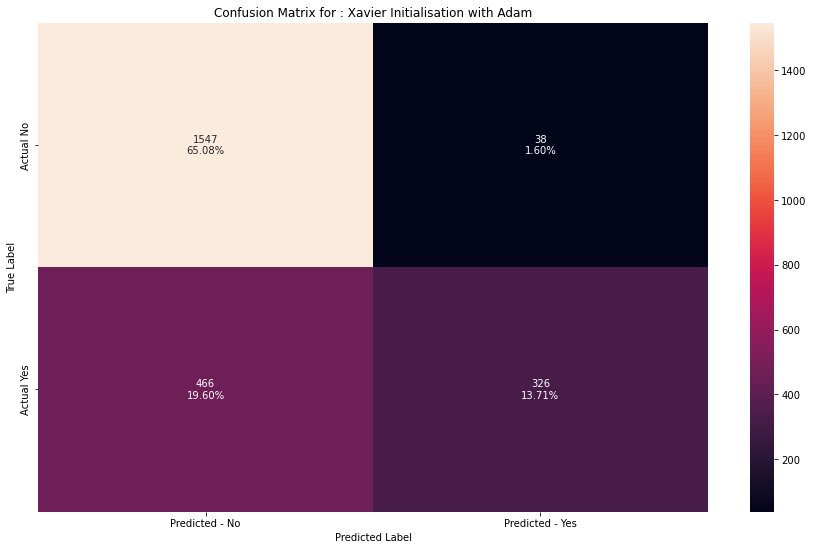

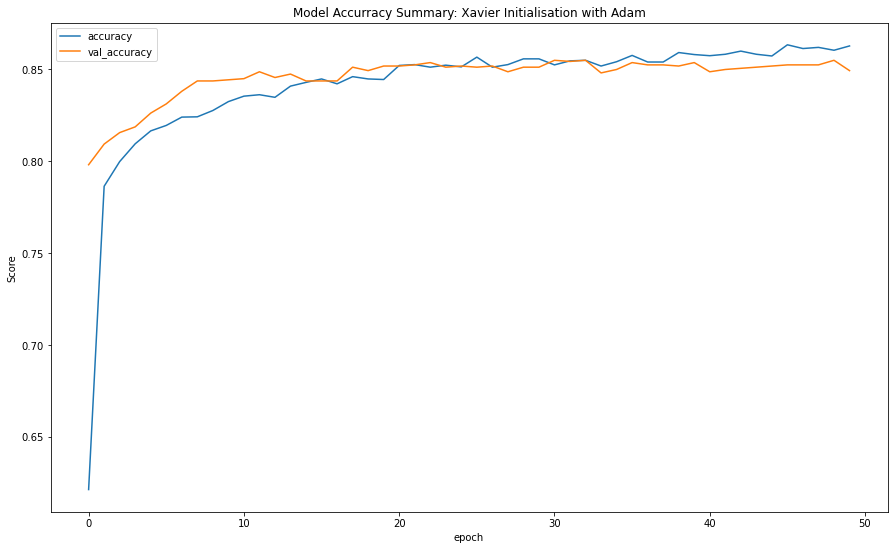

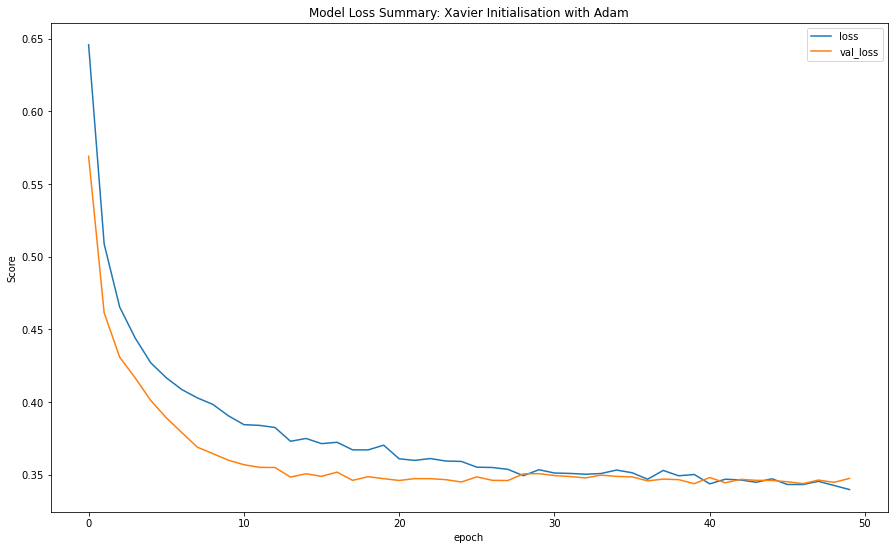

ROC AUC=0.694


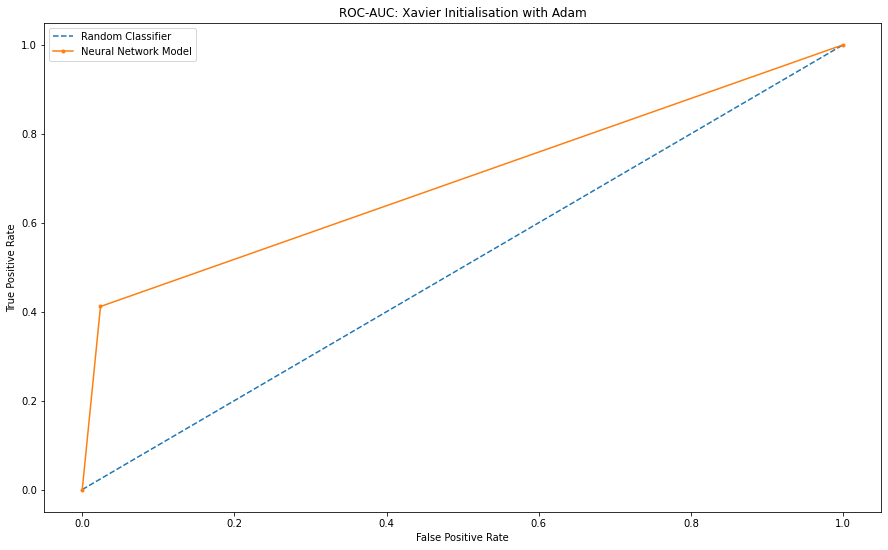

In [58]:
ShowModelStats(
    history       = model_4['History'],
    actual_y      = oversample_model_data['y_test'],
    predictions_y = y_predictions,
    label         = "Xavier Initialisation with Adam")

### Observations 
- Oversampling the data slightly increased the true positives by aproximately 3 percent.
- Next step would be to create a custom Model class and use Bagging classifier and grid search CV to tune hyperparameters 
to find the best model. 

# Model Performance Evaluation

In [59]:
Scores(model_evaluation_scores)

,0,1,2,3
Hidden Layer Activation,relu,relu,relu,relu
Output Layer Activation,sigmoid,sigmoid,sigmoid,sigmoid
Loss,binary_crossentropy,binary_crossentropy,binary_crossentropy,binary_crossentropy
Weight Initialisation,random_normal,HeNormal,GlorotUniform,GlorotUniform
Max Accuracy Train,0.867031,0.857969,0.862813,0.863437
Max Accuracy Test,0.855625,0.854375,0.855,0.855
Max Recall Train,0.545455,0.464561,0.469183,0.496148
Max Recall Test,0.429012,0.401235,0.410494,0.425926


# Conclusion and key takeaways

- Theres a higer positive corrolation bewtween age and the number of customers who left the bank.
- The second highest positive corrolation with the target feature is with the Balance feature. 
- The tenure and the estimated salary features seems to have a very low corolation.
- Majority of the customers have a relatively good credit score.
- Theres more customers in the age range (40,50) who have exited.
- More male customers with a balance > 50000 have exited.
- The propotion of active vs none active members is the same throughout all the countries,
- The bank as more active members who own credit cards.
- The bank has more customers in France and almmost equal number of customers in both Gemerny and Spain.
- The bank has a relatively equal number of male and females in all categories
- Theres more customers who have a credit card than those who do not.
- The ratio of active members to inactive members is aproximately 50/50
- Customers in France are less likely to leave the bank
- Customers in Gemerny are slightly more likely to leave the bank.
- Male customers are slighly more likely to leave the bank compared to Female customers
- There is very low corrolation for tenuer and estimated salary to the target variable.
- The data is very imbalanced with 79.72%  of the bank's customers who have left the bank and 20% who stayed.
- The recall is too low, this may be due to the fact that the data is imbalanced as the true negatives are high and this is also reflected by the EDA. This was the results of random initialisation of weights.
- We can try to address this through a Bagging classifier which will servce as our Data augmentation techinuque
- Altentively we can try our grid search but there are lot of hyper parameters to search for and this would take a very long time and will be left out for the purposes of this assignment.